# Building Mask Detection Model

In [2]:
# Importing all the usefull libraries
from tensorflow import keras
from keras.applications import MobileNetV2
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os

In [4]:
# Initialize the initital learning rate, num of epochs and batch size
INIT_LR = 1e-4
EPOCHS = 20
BATCH_SIZE = 32

In [7]:
DIR = os.path.abspath("dataset")
CATEGORIES = ['with_mask', 'without_mask']

In [8]:
# Loading the images
data = []
labels = []

for category in CATEGORIES:
    path = os.path.join(DIR, category)
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        image = keras.preprocessing.image.load_img(img_path, target_size=(224, 224))  # Loading the image with specified size
        image = keras.preprocessing.image.img_to_array(image)  # Converting the image into numpy array
        image = keras.applications.mobilenet_v2.preprocess_input(image)  # preprocesses the image according to the requirement of the model
        
        data.append(image)
        labels.append(category)

C:\Users\YuvrajSK\Anaconda3\lib\site-packages\PIL\Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [37]:
# Applying one hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = keras.utils.to_categorical(labels)

In [39]:
lb.classes_

array([0, 1])

In [24]:
# Converting data into numpy arrays
data = np.array(data, dtype="float32")

# Spliting the dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(data , labels, test_size=0.2, stratify=labels, random_state=42)

In [26]:
X_train.shape, X_test.shape

((3066, 224, 224, 3), (767, 224, 224, 3))

In [27]:
# Creating training image generator for the data augmentation(creating more data out of the given data using cropping etc techniques)

Aug = keras.preprocessing.image.ImageDataGenerator(
        rotation_range=20,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode = "nearest"
)

In [29]:
# Creating a base(mobilenetv2) and a head model

baseModel = keras.applications.MobileNetV2(weights="imagenet",
                                include_top=False,
                                input_tensor=keras.layers.Input(shape=(224, 224, 3)))

# Adding different layers to the base model
headModel = baseModel.output
headModel = keras.layers.AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = keras.layers.Flatten(name="flatten")(headModel)
headModel = keras.layers.Dense(128, activation="relu")(headModel)
headModel = keras.layers.Dropout(0.5)(headModel)  # Dropout to avoid overfitting of our model
headModel = keras.layers.Dense(2, activation="softmax")(headModel)  # Output layer

C:\Users\YuvrajSK\Anaconda3\lib\site-packages\keras_applications\mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


9412608/9406464 [==============================] - 80s 8us/step


In [30]:
# Creating Actual model
model = keras.models.Model(inputs=baseModel.input, outputs=headModel)

# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
    layer.trainable = False

In [31]:
# Compiling our model
print("[INFO] Compiling the Model...")
opt = keras.optimizers.Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)

model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

[INFO] Compiling the Model...


In [32]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
______________________________________________________________________________________________

## Training the Model

In [33]:
# Training the model
print("[INFO] Training the head model...")

H = model.fit(Aug.flow(X_train, y_train, batch_size=BATCH_SIZE),
              steps_per_epoch=len(X_train) // BATCH_SIZE,
              validation_data=(X_test, y_test),
              validation_steps=len(X_test) // BATCH_SIZE,
              epochs=EPOCHS)

[INFO] Training the head model...
  ...
    to  
  ['...']
Train for 95 steps, validate on 767 samples
Epoch 1/20
95/95 [==============================] - 429s 5s/step - loss: 0.5855 - accuracy: 0.7057 - val_loss: 0.3846 - val_accuracy: 0.8111
Epoch 2/20
95/95 [==============================] - 336s 4s/step - loss: 0.3140 - accuracy: 0.8754 - val_loss: 0.5411 - val_accuracy: 0.7731
Epoch 3/20
95/95 [==============================] - 339s 4s/step - loss: 0.2257 - accuracy: 0.9199 - val_loss: 0.4044 - val_accuracy: 0.8492
Epoch 4/20
95/95 [==============================] - 352s 4s/step - loss: 0.1781 - accuracy: 0.9286 - val_loss: 0.3483 - val_accuracy: 0.8655
Epoch 5/20
95/95 [==============================] - 343s 4s/step - loss: 0.1597 - accuracy: 0.9417 - val_loss: 0.3865 - val_accuracy: 0.8505
Epoch 6/20
95/95 [==============================] - 343s 4s/step - loss: 0.1376 - accuracy: 0.9522 - val_loss: 0.3398 - val_accuracy: 0.8750
Epoch 7/20
95/95 [==============================] -

In [34]:
# Evaluating the model on test dataset
print("[INFO] Evaluating network...")
predIdxs = model.predict(X_test, batch_size=BATCH_SIZE)

# Saving the maximum probality class
predIdxs = np.argmax(predIdxs, axis=1)

[INFO] Evaluating network...


In [49]:
# Classification Report
print(classification_report(y_test.argmax(axis=1), predIdxs))

              precision    recall  f1-score   support

           0       1.00      0.79      0.88       383
           1       0.82      1.00      0.90       384

    accuracy                           0.89       767
   macro avg       0.91      0.89      0.89       767
weighted avg       0.91      0.89      0.89       767



In [46]:
# Saving the Model
print("[INFO] Saving the Mask Detector model.....")
model.save("mask_detector.h5", save_format="h5")

[INFO] Saving the Mask Detector model.....


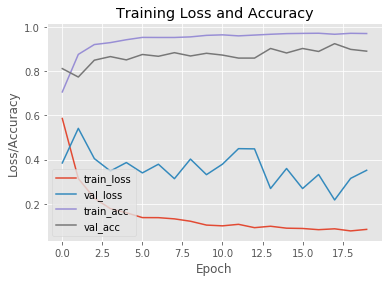

In [47]:
# Plotting the training stats
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")